### SVM classification, example 1, Social Network Ads, data

In [ ]:
# usual imports in a classic ML pipeline for Classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics, svm

# additional metrics ONLY for classification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.calibration import CalibratedClassifierCV

In [18]:
# load the data
df = pd.read_csv("Social_Network_Ads.csv")


# let's quickly see the first 5 rows of data
df

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [19]:
# check duplicates 
df.duplicated().sum()

np.int64(0)

In [20]:
# USER id is an identifier, drop it 
df = df.drop("User ID", axis=1)

In [21]:
df['Gender'].value_counts()

Gender
Female    204
Male      196
Name: count, dtype: int64

**Step 2: handle categoricals**

We only have one binary variable, so we don't need to process other types of categoricals.

In [22]:
# this just converts the value of column to 0 or 1
# factorize in pandas works too, but only one column at a time
from sklearn.preprocessing import LabelEncoder
variables = ['Gender']
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

**There's no ordinal or nominal categories here, we can proceed to X/y -phase**

In [23]:
df.head()

,Gender,Age,EstimatedSalary,Purchased
0,1,19,19000,0
1,1,35,20000,0
2,0,26,43000,0
3,0,27,57000,0
4,1,19,76000,0


### X/y and train/test -splits

In [24]:
# first step, we split our data into SUPPORT variables and the TARGET variable
# X => support variables, y => target variable

# X => list of support variables the model uses 
# while predicting the target variable with the model
X = df.drop("Purchased", axis=1)

# our target variable is y
y = df['Purchased']

In [25]:
# secondly, train/test -split with scikit-learn's helper function
# 0.3 for testing => 30% of data is reserved for testing purposes
# and based on that => it's deduced that 70% will be in the training data

# you can also define the random state, which is sometimes useful
# if you want to "lock down" all the randomness in order to get same results every time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Train the logistic regression model

In [ ]:
# create the model and train it with the data
# model = LogisticRegression()
# use probability=True for easier metrics

# if you wish to use LinearSVC => we need to wrap it into a
# CalibratedClassifierCV so it outputs probabilities for the metrics
# model = make_pipeline(StandardScaler(), CalibratedClassifierCV(svm.LinearSVC()))

model = make_pipeline(StandardScaler(), svm.SVC(probability=True))
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('standardscaler', ...), ('svc', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'


### Classification error metrics

In [27]:
# we need to create test predictions based on our earlier reserved test dataset
# this data has never been seen by the model by now
predictions = model.predict(X_test)

In [28]:
# print the classification report based on true values and predictions
print(classification_report(y_test, predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        66
           1       0.84      0.91      0.87        34

    accuracy                           0.91       100
   macro avg       0.90      0.91      0.90       100
weighted avg       0.91      0.91      0.91       100


Model overall accuracy: 91.00%


<Axes: >

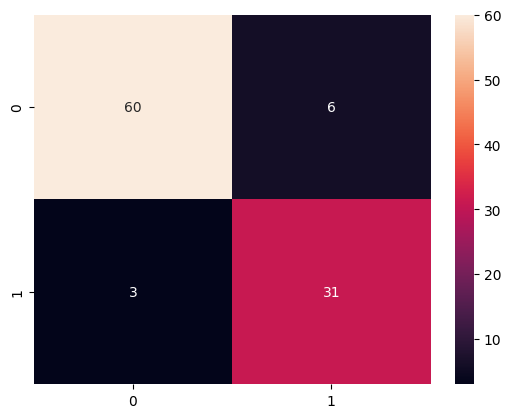

In [29]:
# see the confusion matrix
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')


In [30]:
# The AUC score is a super sensitive metric
# you often get low scores, even 0.5

# in binary logistic regression, AUC values are often interpreted as follows:
# A binary classifier is useful only when it achieves ROC-AUC score greater than 0.5 and as near to 1 as possible. 
# If a classifier yields a score less than 0.5, it simply means that the model is performing worse 
# than a random classifier, and therefore is useless.

# In multinomial logistic regression , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# basically 0.5 means you could get the same result with just random guessing
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.9701426024955436

### Using the model in practice

In [31]:
df.columns

Index(['Gender', 'Age', 'EstimatedSalary', 'Purchased'], dtype='str')

In [32]:
# usually in GUI application we save the model-object / variable into a file (by using joblib-module)
# and in the GUI application => we load the saved model from the file
# and use the model just like here below


# map all the variables from the user
# into a Python dictionary
# the variable names have to match with the original dataset
tester_row = {
    'Gender': 0,
    'Age': 55, 
    'EstimatedSalary': 30000
}

# convert to pandas format
tester_row = pd.DataFrame([tester_row])


In [33]:
print("All probabilities by category:")
print(model.predict_proba(tester_row))
print()

# change these based on your original data
labels = ["No", "Yes"]

print("Did this customer buy the service (Yes/No):")
result = labels[model.predict(tester_row)[0]]
print(result)
print("-------------------")

All probabilities by category:
[[0.03926305 0.96073695]]

Did this customer buy the service (Yes/No):
Yes
-------------------


In [34]:
df.corr()

,Gender,Age,EstimatedSalary,Purchased
Gender,1.000000,-0.073741,-0.060435,-0.042469
Age,-0.073741,1.000000,0.155238,0.622454
EstimatedSalary,-0.060435,0.155238,1.000000,0.362083
Purchased,-0.042469,0.622454,0.362083,1.000000
